<h3>导入包</h3>

In [45]:
import os
from datetime import datetime
from chinese_calendar import is_workday
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor


warnings.filterwarnings('ignore')

<h3>读入数据</h3>

In [46]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])
data_dict

{'二层插座':                      time     value
 0     2013-08-03 00:00:00  0.164062
 1     2013-08-03 00:15:00  0.121094
 2     2013-08-03 00:30:00  0.101562
 3     2013-08-03 00:45:00  0.087891
 4     2013-08-03 01:00:00  0.103516
 ...                   ...       ...
 63395 2015-08-03 22:45:00  0.082031
 63396 2015-08-03 23:00:00  0.128906
 63397 2015-08-03 23:15:00  0.125000
 63398 2015-08-03 23:30:00  0.082031
 63399 2015-08-03 23:45:00  0.160156
 
 [63400 rows x 2 columns], '二层照明':                      time     value
 0     2013-08-03 00:00:00  0.500000
 1     2013-08-03 00:15:00  0.507812
 2     2013-08-03 00:30:00  0.476562
 3     2013-08-03 00:45:00  0.117188
 4     2013-08-03 01:00:00  0.000000
 ...                   ...       ...
 63643 2015-08-03 22:45:00  0.000000
 63644 2015-08-03 23:00:00  0.000000
 63645 2015-08-03 23:15:00  0.000000
 63646 2015-08-03 23:30:00  0.000000
 63647 2015-08-03 23:45:00  0.000000
 
 [63648 rows x 2 columns], '一层插座':                      time     v

<h3>读入天气数据</h3>

In [47]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%),time
0,28,88,1.0,1006,东南风,159,9,71,2013-08-03 00:00:00
1,28,88,0.9,1006,东南风,155,8,75,2013-08-03 01:00:00
2,28,89,0.7,1006,东南风,150,8,54,2013-08-03 02:00:00
3,27,90,0.5,1006,东南风,151,8,25,2013-08-03 03:00:00
4,27,90,0.2,1006,东南风,151,8,35,2013-08-03 04:00:00
...,...,...,...,...,...,...,...,...,...
18043,27,67,0.0,1006,东北风,43,11,1,2015-08-24 19:00:00
18044,26,72,0.0,1007,东北风,45,9,0,2015-08-24 20:00:00
18045,25,75,0.4,1007,东北风,35,7,2,2015-08-24 21:00:00
18046,24,78,0.7,1007,东北风,25,6,1,2015-08-24 22:00:00


<h3>处理缺失数据</h3>
<ul>
<li>由于大赛提供的数据表存在不同程度的数据缺失问题，将数据对其、合并，并将缺失数据删除。</li>
<li>由于大赛提供的数据表存在不同程度的数据缺失问题，将数据对其、合并，并将缺失数据删除。</li>
</ul>

In [48]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
63160,2015-08-03 22:45:00,0.082031,0.000000,0.097656,0.250000,2.250000
63161,2015-08-03 23:00:00,0.128906,0.000000,0.175781,0.242188,2.343750
63162,2015-08-03 23:15:00,0.125000,0.000000,0.101562,0.226562,2.093750
63163,2015-08-03 23:30:00,0.082031,0.000000,0.164062,0.171875,2.312500


<h3>将一层、二层插座能耗相加，一层、二层照明能耗相加构造数据：</h3>

In [49]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data

,time,value_air,value_socket,value_light
0,2013-08-03 00:00:00,4.234375,0.277344,1.042969
1,2013-08-03 00:15:00,5.093750,0.394531,1.050781
2,2013-08-03 00:30:00,3.234375,0.378906,0.992188
3,2013-08-03 00:45:00,3.187500,0.306641,0.554688
4,2013-08-03 01:00:00,3.171875,0.185547,0.406250
...,...,...,...,...
63160,2015-08-03 22:45:00,2.250000,0.179688,0.250000
63161,2015-08-03 23:00:00,2.343750,0.304688,0.242188
63162,2015-08-03 23:15:00,2.093750,0.226562,0.226562
63163,2015-08-03 23:30:00,2.312500,0.246094,0.171875


<h3>将数据尺度调整为每小时，并根据赛题要求选定数据范围，构造特征：</h3>

In [50]:
data['workday'] = data["time"].apply(lambda x: is_workday(x)).astype(int)
data['hour'] = data['time'].dt.hour
data['week'] = data['time'].dt.weekday
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data = data.groupby(["year",'month','day','week','hour','workday'])[['value_socket','value_light','value_air']].sum().reset_index()
data

,year,month,day,week,hour,workday,value_socket,value_light,value_air
0,2013,8,3,5,0,0,1.357422,3.640625,15.750000
1,2013,8,3,5,1,0,0.785156,1.621094,12.390625
2,2013,8,3,5,2,0,0.771484,1.632812,10.953125
3,2013,8,3,5,3,0,0.830078,1.613281,11.343750
4,2013,8,3,5,4,0,1.162109,1.812500,12.671875
...,...,...,...,...,...,...,...,...,...
15887,2015,8,3,0,19,1,1.367188,2.851562,22.593750
15888,2015,8,3,0,20,1,1.402344,1.687500,19.281250
15889,2015,8,3,0,21,1,1.273438,1.609375,16.312500
15890,2015,8,3,0,22,1,1.035156,1.046875,9.062500


<h3>同样处理天气数据，并进行merge：</h3>

In [51]:
wh['hour'] = wh['time'].dt.hour
wh['week'] = wh['time'].dt.weekday
wh['day'] = wh['time'].dt.day
wh['month'] = wh['time'].dt.month
wh['year'] = wh['time'].dt.year
data = pd.merge(data,wh,on=['hour','week','day','month','year'], how="inner")
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>对风向进行onehot</h4>

In [52]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0]).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,year,month,day,week,hour,workday,value_socket,value_light,value_air,temp,...,cloud,time,东北风,东南风,东风,北风,南风,西北风,西南风,西风
0,2013,8,3,5,0,0,1.357422,3.640625,15.750000,28,...,71,2013-08-03 00:00:00,0,1,0,0,0,0,0,0
1,2013,8,3,5,1,0,0.785156,1.621094,12.390625,28,...,75,2013-08-03 01:00:00,0,1,0,0,0,0,0,0
2,2013,8,3,5,2,0,0.771484,1.632812,10.953125,28,...,54,2013-08-03 02:00:00,0,1,0,0,0,0,0,0
3,2013,8,3,5,3,0,0.830078,1.613281,11.343750,27,...,25,2013-08-03 03:00:00,0,1,0,0,0,0,0,0
4,2013,8,3,5,4,0,1.162109,1.812500,12.671875,27,...,35,2013-08-03 04:00:00,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15887,2015,8,3,0,19,1,1.367188,2.851562,22.593750,36,...,100,2015-08-03 19:00:00,0,0,0,0,1,0,0,0
15888,2015,8,3,0,20,1,1.402344,1.687500,19.281250,35,...,100,2015-08-03 20:00:00,0,0,0,0,1,0,0,0
15889,2015,8,3,0,21,1,1.273438,1.609375,16.312500,33,...,100,2015-08-03 21:00:00,0,0,0,0,0,0,1,0
15890,2015,8,3,0,22,1,1.035156,1.046875,9.062500,32,...,98,2015-08-03 22:00:00,0,0,0,0,0,0,1,0


<h4>对星期几进行onehot</h4>

In [53]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0]).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,year,month,day,hour,workday,value_socket,value_light,value_air,temp,humidity,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
0,2013,8,3,0,0,1.357422,3.640625,15.750000,28,88,...,0,0,0,0,0,0,0,0,1,0
1,2013,8,3,1,0,0.785156,1.621094,12.390625,28,88,...,0,0,0,0,0,0,0,0,1,0
2,2013,8,3,2,0,0.771484,1.632812,10.953125,28,89,...,0,0,0,0,0,0,0,0,1,0
3,2013,8,3,3,0,0.830078,1.613281,11.343750,27,90,...,0,0,0,0,0,0,0,0,1,0
4,2013,8,3,4,0,1.162109,1.812500,12.671875,27,90,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15887,2015,8,3,19,1,1.367188,2.851562,22.593750,36,55,...,0,0,0,1,0,0,0,0,0,0
15888,2015,8,3,20,1,1.402344,1.687500,19.281250,35,57,...,0,0,0,1,0,0,0,0,0,0
15889,2015,8,3,21,1,1.273438,1.609375,16.312500,33,57,...,0,1,0,1,0,0,0,0,0,0
15890,2015,8,3,22,1,1.035156,1.046875,9.062500,32,57,...,0,1,0,1,0,0,0,0,0,0


<h3>绘制曲线：</h3>

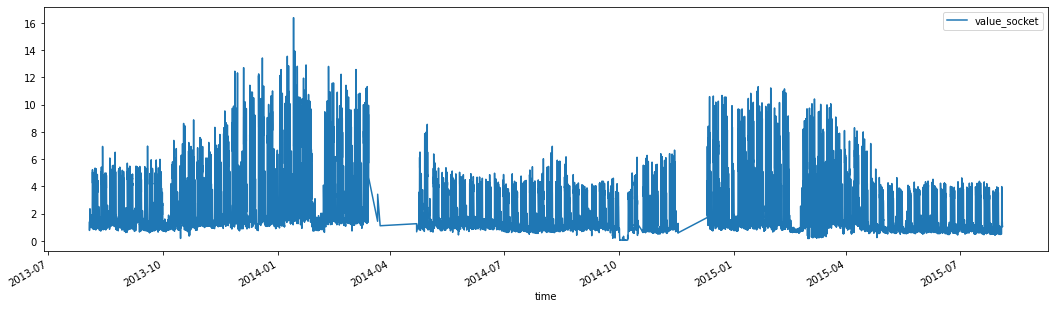

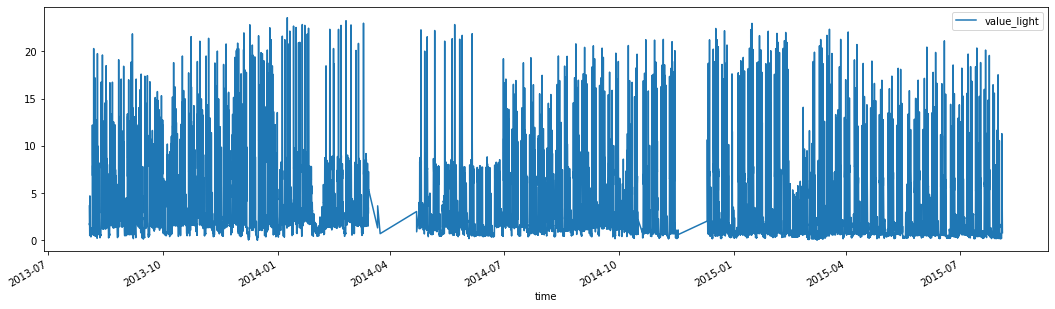

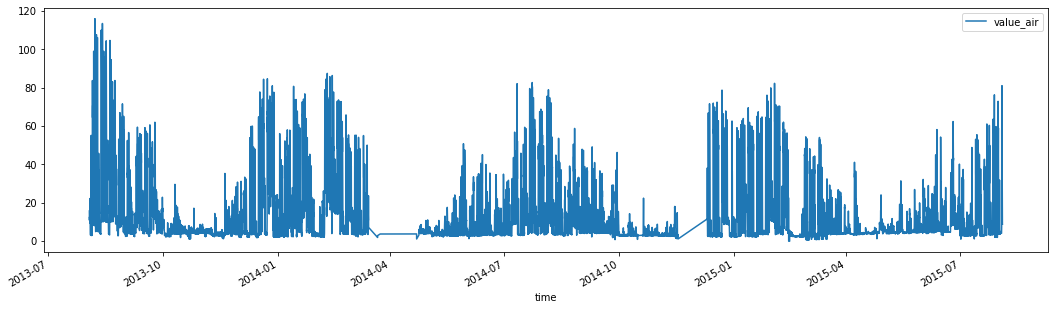

In [54]:
data.plot("time","value_socket",figsize=(18,5))
data.plot("time","value_light",figsize=(18,5))
data.plot("time","value_air",figsize=(18,5))
data.drop('time', axis=1, inplace=True)

<h3>多步直接预测</h3>
<ul>
<li>这里采用多步直接预测来构建数据；</li>
</ul>

In [55]:
data_socket = data.copy()
for i in range(7*24):
    data_socket['value_socket_{}'.format(i)] = data_socket['value_socket'].shift(-i-1)
data_socket.dropna(inplace=True)
data_socket

,year,month,day,hour,workday,value_socket,value_light,value_air,temp,humidity,...,value_socket_158,value_socket_159,value_socket_160,value_socket_161,value_socket_162,value_socket_163,value_socket_164,value_socket_165,value_socket_166,value_socket_167
0,2013,8,3,0,0,1.357422,3.640625,15.750000,28,88,...,2.591797,2.384766,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844
1,2013,8,3,1,0,0.785156,1.621094,12.390625,28,88,...,2.384766,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531
2,2013,8,3,2,0,0.771484,1.632812,10.953125,28,89,...,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828
3,2013,8,3,3,0,0.830078,1.613281,11.343750,27,90,...,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828,1.753906
4,2013,8,3,4,0,1.162109,1.812500,12.671875,27,90,...,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828,1.753906,1.794922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15719,2015,7,27,18,1,2.238281,6.000000,34.656250,35,61,...,3.914062,3.519531,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188
15720,2015,7,27,19,1,1.562500,4.117188,12.187500,34,66,...,3.519531,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344
15721,2015,7,27,20,1,1.371094,2.203125,4.562500,33,71,...,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344,1.273438
15722,2015,7,27,21,1,1.070312,1.554688,3.812500,32,72,...,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344,1.273438,1.035156


<h3>划分训练集、验证数据集：</h3>

In [56]:
targets = [item for item in data_socket.columns if 'value_socket_' in item]

X_train_socket = data_socket.drop(targets, axis=1)[: int(len(data_socket) * 0.95)]
y_train_socket = data_socket[targets][: int(len(data_socket) * 0.95)]

X_test_socket = data_socket.drop(targets, axis=1)[int(len(data_socket) * 0.95) :]
y_test_socket = data_socket[targets][int(len(data_socket) * 0.95) :]

X_train_socket

,year,month,day,hour,workday,value_socket,value_light,value_air,temp,humidity,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
0,2013,8,3,0,0,1.357422,3.640625,15.750000,28,88,...,0,0,0,0,0,0,0,0,1,0
1,2013,8,3,1,0,0.785156,1.621094,12.390625,28,88,...,0,0,0,0,0,0,0,0,1,0
2,2013,8,3,2,0,0.771484,1.632812,10.953125,28,89,...,0,0,0,0,0,0,0,0,1,0
3,2013,8,3,3,0,0.830078,1.613281,11.343750,27,90,...,0,0,0,0,0,0,0,0,1,0
4,2013,8,3,4,0,1.162109,1.812500,12.671875,27,90,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14932,2015,6,24,23,1,0.910156,0.796875,8.750000,22,92,...,0,0,0,0,0,1,0,0,0,0
14933,2015,6,25,0,1,0.851562,1.093750,12.125000,21,92,...,0,0,0,0,0,0,1,0,0,0
14934,2015,6,25,1,1,0.675781,0.460938,8.687500,21,93,...,0,0,0,0,0,0,1,0,0,0
14935,2015,6,25,2,1,0.578125,0.500000,8.812500,20,93,...,0,0,0,0,0,0,1,0,0,0


In [57]:
y_train_socket

,value_socket_0,value_socket_1,value_socket_2,value_socket_3,value_socket_4,value_socket_5,value_socket_6,value_socket_7,value_socket_8,value_socket_9,...,value_socket_158,value_socket_159,value_socket_160,value_socket_161,value_socket_162,value_socket_163,value_socket_164,value_socket_165,value_socket_166,value_socket_167
0,0.785156,0.771484,0.830078,1.162109,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,...,2.591797,2.384766,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844
1,0.771484,0.830078,1.162109,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,2.359375,...,2.384766,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531
2,0.830078,1.162109,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,2.359375,1.449219,...,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828
3,1.162109,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,2.359375,1.449219,1.496094,...,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828,1.753906
4,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,2.359375,1.449219,1.496094,1.976562,...,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828,1.753906,1.794922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14932,0.851562,0.675781,0.578125,0.605469,0.601562,0.867188,1.222656,1.171875,1.214844,3.796875,...,2.558594,2.929688,3.320312,2.933594,1.640625,1.226562,0.988281,1.117188,0.890625,1.066406
14933,0.675781,0.578125,0.605469,0.601562,0.867188,1.222656,1.171875,1.214844,3.796875,3.425781,...,2.929688,3.320312,2.933594,1.640625,1.226562,0.988281,1.117188,0.890625,1.066406,0.964844
14934,0.578125,0.605469,0.601562,0.867188,1.222656,1.171875,1.214844,3.796875,3.425781,3.660156,...,3.320312,2.933594,1.640625,1.226562,0.988281,1.117188,0.890625,1.066406,0.964844,0.835938
14935,0.605469,0.601562,0.867188,1.222656,1.171875,1.214844,3.796875,3.425781,3.660156,3.332031,...,2.933594,1.640625,1.226562,0.988281,1.117188,0.890625,1.066406,0.964844,0.835938,0.921875


<h3>自回归模型构建</h3>
<ul>
<li>这里我们使用Auto-regressive distributed lags来构建模型，并使用LightGBM进行预测；</li>
</ul>

In [58]:
model_socket = MultiOutputRegressor(lgb.LGBMRegressor(objective='regression')).fit(X_train_socket, y_train_socket)

<h3>使用划分出的测试集测试：</h3>

In [59]:
pred_socket = pd.DataFrame(model_socket.predict(X_test_socket), columns=targets)
pred_socket.index = y_test_socket.index
pred_socket

,value_socket_0,value_socket_1,value_socket_2,value_socket_3,value_socket_4,value_socket_5,value_socket_6,value_socket_7,value_socket_8,value_socket_9,...,value_socket_158,value_socket_159,value_socket_160,value_socket_161,value_socket_162,value_socket_163,value_socket_164,value_socket_165,value_socket_166,value_socket_167
14937,0.867154,1.058633,1.171845,1.238828,3.613061,3.403327,3.436926,3.445649,3.312894,3.166108,...,1.319019,1.380666,1.252404,1.143717,1.220462,0.901922,0.783660,0.815915,0.762360,0.754314
14938,1.060452,1.139705,1.335054,3.526884,3.206573,3.404184,3.388686,3.047583,3.179641,3.272696,...,1.265239,1.375135,1.255425,1.171799,1.049610,0.844763,0.801521,0.836072,0.808555,0.904060
14939,1.488716,1.726924,3.987326,3.492815,3.442467,3.267090,3.214156,3.294124,3.351249,3.164568,...,1.343828,1.379373,1.315023,1.016831,0.912370,0.858289,0.816399,0.936347,1.004922,1.219276
14940,1.380394,3.569589,3.335075,3.477730,3.289367,3.032129,3.153789,3.115914,3.324725,2.830280,...,1.343828,1.439766,1.074040,0.965798,0.907890,0.866856,0.827055,0.964802,1.053643,1.236630
14941,3.688375,3.524955,3.564926,3.614586,3.036821,3.109942,3.238798,3.224569,2.917877,2.018015,...,1.369135,1.137665,0.868653,0.965798,0.901572,0.835639,0.959584,1.047983,1.128657,1.432820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15719,1.745759,1.382784,1.315985,1.267103,1.311787,1.087621,0.961470,0.899049,0.803478,0.811979,...,3.530459,3.687297,3.461273,3.457979,3.429724,3.454867,3.363807,3.332800,2.679674,2.027761
15720,1.297636,1.218405,1.177255,1.171956,1.033361,0.906682,0.850659,0.889845,0.833280,0.974790,...,3.261214,3.605600,3.328116,3.238706,3.302813,3.450819,3.202189,3.003521,2.038521,1.509435
15721,1.283090,1.233645,1.283949,1.061156,0.881690,0.897063,0.897429,0.909989,1.051538,1.245423,...,3.310625,3.641143,3.283659,3.260806,3.259678,3.365862,2.897607,1.966746,1.613480,1.256358
15722,1.093287,1.372032,0.857418,0.756882,0.784220,0.796643,0.766952,0.974111,1.137435,1.239032,...,3.144739,3.459400,3.145809,3.185621,3.257650,2.788766,1.877461,1.422411,1.362235,1.231617


In [60]:
y_test_socket

,value_socket_0,value_socket_1,value_socket_2,value_socket_3,value_socket_4,value_socket_5,value_socket_6,value_socket_7,value_socket_8,value_socket_9,...,value_socket_158,value_socket_159,value_socket_160,value_socket_161,value_socket_162,value_socket_163,value_socket_164,value_socket_165,value_socket_166,value_socket_167
14937,0.867188,1.222656,1.171875,1.214844,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,...,1.226562,0.988281,1.117188,0.890625,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281
14938,1.222656,1.171875,1.214844,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,3.171875,...,0.988281,1.117188,0.890625,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281,1.285156
14939,1.171875,1.214844,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,3.171875,3.019531,...,1.117188,0.890625,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281,1.285156,1.242188
14940,1.214844,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,3.171875,3.019531,2.503906,...,0.890625,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281,1.285156,1.242188,1.464844
14941,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,3.171875,3.019531,2.503906,2.019531,...,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281,1.285156,1.242188,1.464844,1.359375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15719,1.562500,1.371094,1.070312,1.027344,1.101562,0.929688,0.585938,0.617188,0.492188,0.527344,...,3.914062,3.519531,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188
15720,1.371094,1.070312,1.027344,1.101562,0.929688,0.585938,0.617188,0.492188,0.527344,0.894531,...,3.519531,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344
15721,1.070312,1.027344,1.101562,0.929688,0.585938,0.617188,0.492188,0.527344,0.894531,1.195312,...,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344,1.273438
15722,1.027344,1.101562,0.929688,0.585938,0.617188,0.492188,0.527344,0.894531,1.195312,1.242188,...,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344,1.273438,1.035156


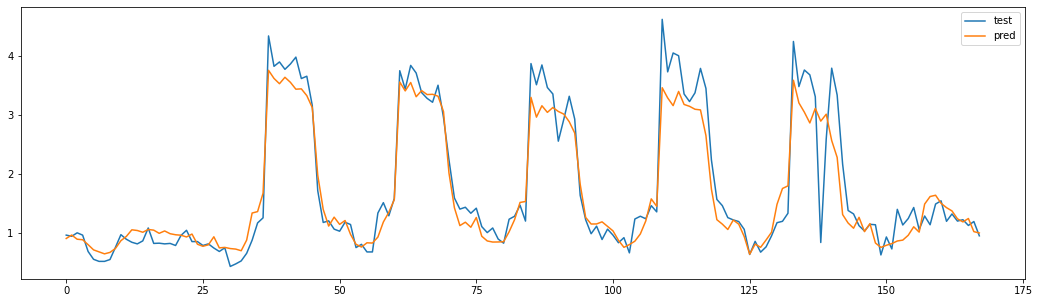

In [61]:
pred_num_socket = pred_socket.loc[15000,:].tolist()
y_test_num_socket = y_test_socket.loc[15000,:].tolist()
plt.figure(figsize=(18,5))
plt.plot(y_test_num_socket, label="test")
plt.plot(pred_num_socket, label="pred")
plt.legend()

<h3>分别计算七天的R2，并按照大赛评分标准计算R2_T_socket：</h3>

In [62]:
R2_list_socket = []
weight_socket = [0.25, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1]
for day in range(7):
    day_list = []
    for i in range(day*24,(day+1)*24):
        day_list.append('value_socket_{}'.format(i))
    pred_day_socket = pred_socket[day_list]
    test_day_socket = y_test_socket[day_list]
    R2_list_socket.append(r2_score(test_day_socket, pred_day_socket))
R2_T_socket = np.multiply(np.array(weight_socket), np.array(R2_list_socket)).sum()
R2_T_socket

0.8928087866350087

<h3>同样的方法预测照明能耗，并计算R2_T_light：</h3>

In [63]:
data_light = data.copy()
for i in range(7*24):
    data_light['value_light_{}'.format(i)] = data_light['value_light'].shift(-i-1)
data_light.dropna(inplace=True)

targets = [item for item in data_light.columns if 'value_light_' in item]

X_train_light = data_light.drop(targets, axis=1)[: int(len(data_light) * 0.95)]
y_train_light = data_light[targets][: int(len(data_light) * 0.95)]

X_test_light = data_light.drop(targets, axis=1)[int(len(data_light) * 0.95) :]
y_test_light = data_light[targets][int(len(data_light) * 0.95) :]

model_light = MultiOutputRegressor(lgb.LGBMRegressor(objective='regression')).fit(X_train_light, y_train_light)

pred_light = pd.DataFrame(model_light.predict(X_test_light), columns=targets)
pred_light.index = y_test_light.index

R2_list_light = []
weight_light = [0.25, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1]
for day in range(7):
    day_list = []
    for i in range(day*24,(day+1)*24):
        day_list.append('value_light_{}'.format(i))
    pred_day_light = pred_light[day_list]
    test_day_light = y_test_light[day_list]
    R2_list_light.append(r2_score(test_day_light, pred_day_light))
R2_T_light = np.multiply(np.array(weight_light), np.array(R2_list_light)).sum()
R2_T_light

0.8250836386687992

<h3>同样的方法预测空调能耗，并计算R2_T_air：</h3>

In [64]:
data_air = data.copy()
for i in range(7*24):
    data_air['value_air_{}'.format(i)] = data_air['value_air'].shift(-i-1)
data_air.dropna(inplace=True)

targets = [item for item in data_air.columns if 'value_air_' in item]

X_train_air = data_air.drop(targets, axis=1)[: int(len(data_air) * 0.95)]
y_train_air = data_air[targets][: int(len(data_air) * 0.95)]

X_test_air = data_air.drop(targets, axis=1)[int(len(data_air) * 0.95) :]
y_test_air = data_air[targets][int(len(data_air) * 0.95) :]

model_air = MultiOutputRegressor(lgb.LGBMRegressor(objective='regression')).fit(X_train_air, y_train_air)

pred_air = pd.DataFrame(model_air.predict(X_test_air), columns=targets)
pred_air.index = y_test_air.index

R2_list_air = []
weight_air = [0.25, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1]
for day in range(7):
    day_list = []
    for i in range(day*24,(day+1)*24):
        day_list.append('value_air_{}'.format(i))
    pred_day_air = pred_air[day_list]
    test_day_air = y_test_air[day_list]
    R2_list_air.append(r2_score(test_day_air, pred_day_air))
R2_T_air = np.multiply(np.array(weight_air), np.array(R2_list_air)).sum()
R2_T_air

0.5978085590083293

<h3>计算总能耗，并计算R2_T_total：</h3>

In [65]:
for i in range(7*24):
    y_test_air = y_test_air.rename(columns={"value_air_{}".format(i):"value_total_{}".format(i)})
    y_test_light = y_test_light.rename(columns={"value_light_{}".format(i):"value_total_{}".format(i)})
    y_test_socket = y_test_socket.rename(columns={"value_socket_{}".format(i):"value_total_{}".format(i)})
    pred_air = pred_air.rename(columns={"value_air_{}".format(i):"value_total_{}".format(i)})
    pred_light = pred_light.rename(columns={"value_light_{}".format(i):"value_total_{}".format(i)})
    pred_socket = pred_socket.rename(columns={"value_socket_{}".format(i):"value_total_{}".format(i)})
y_test_total = y_test_air + y_test_light + y_test_socket
pred_total = pred_air + pred_light + pred_socket

y_test_total = y_test_air + y_test_light + y_test_socket
pred_total = pred_air + pred_light + pred_socket
R2_list_total = []
weight_total = [0.25, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1]
for day in range(7):
    day_list = []
    for i in range(day*24,(day+1)*24):
        day_list.append('value_total_{}'.format(i))
    pred_day_total = pred_total[day_list]
    test_day_total = y_test_total[day_list]
    R2_list_total.append(r2_score(test_day_total, pred_day_total))
R2_T_total = np.multiply(np.array(weight_total), np.array(R2_list_total)).sum()
R2_T_total

0.7137503758376189

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [66]:
final_test_input = data.iloc[-1:]
final_pred_socket = model_socket.predict(final_test_input)
final_pred_light = model_light.predict(final_test_input)
final_pred_air = model_air.predict(final_test_input)
results = pd.DataFrame()
results['socket'] = final_pred_socket[0]
results['light'] = final_pred_light[0]
results['air'] = final_pred_air[0]
results['total'] = results.sum(axis=1)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
0,8.356251,0.938245,0.838417,6.579590
1,7.497304,0.785699,0.491229,6.220375
2,7.775700,0.669731,0.484890,6.621080
3,6.342630,0.681266,0.500235,5.161130
4,6.190814,0.699274,0.307251,5.184288
...,...,...,...,...
163,25.034822,1.478974,3.361415,20.194433
164,13.845879,1.203953,2.259954,10.381971
165,10.219550,1.311261,1.682914,7.225375
166,10.104945,1.130791,1.127571,7.846583


In [67]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)